In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# mount google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  test.txt  train.txt  val.txt


# **Reading dataset and separating them as text and label**

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/paper/train.txt", sep=";", header= None, names=["text", "label"])
test_df = pd.read_csv("/content/drive/My Drive/paper/test.txt", sep=";", header= None, names=["text", "label"])
val_df = pd.read_csv("/content/drive/My Drive/paper/val.txt", sep=";", header= None, names=["text", "label"])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Checking for null values in data

In [ ]:
train_df.info()
print()
test_df.info()
print()
val_df.info()
print("887")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
887


# Distriution of labels in Train and Test data

In [ ]:
train_df["label"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
test_df["label"].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

# A sample text from the dataset

In [ ]:
sample = train_df["text"][1]
print(sample)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


# Text Preprocessing
The preprocessing is done in a few steps:
* Lowercaseing the text
* Removing Numbers
* Removing Punctuations
* Removing Stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [ ]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)

    return text

In [ ]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

# Raw text vs Preprocessed Text

In [ ]:
train_df.head()

,text,label,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


# Label Encoding Labels
This means replcing String objects as labels with integer values

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["encoded_train_label"] = label_encoder.fit_transform(train_df["label"])
val_df["encoded_val_label"] = label_encoder.transform(val_df["label"])
test_df["encoded_test_label"] = label_encoder.transform(test_df["label"])

In [ ]:
train_df[['label', 'encoded_train_label']].drop_duplicates(keep='first')

,label,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
x_train, x_test, y_train, y_test = train_df["clean_text"], val_df["clean_text"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [ ]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

# Converting texts to vectors via tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["clean_text"])

vocab_size = len(tokenizer.word_index) + 1

# Calculating maximum length of a vector

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


# Zero padding every vector so that they are the same size

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

# One Hot Encoding integer labels

In [ ]:
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

# Reading GloVe

In [ ]:
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('/content/drive/My Drive/paper/glove.840B.300d.txt','r',encoding='utf-8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector

    return embedding_matrix
print("done")

done


In [ ]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 2196018it [03:44, 9782.87it/s] 


# Defining CNN-BiLSTM model

In [ ]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           4519500   
                                                                 
 dropout (Dropout)           (None, 35, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 33, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 11, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 32)             3104      
                                                        

In [ ]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback])
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
125/125 [==============================] - 29s 194ms/step - loss: 1.3970 - accuracy: 0.4542 - val_loss: 0.9570 - val_accuracy: 0.6010
Epoch 2/30
125/125 [==============================] - 25s 198ms/step - loss: 0.8051 - accuracy: 0.6948 - val_loss: 0.4390 - val_accuracy: 0.8585
Epoch 3/30
125/125 [==============================] - 22s 176ms/step - loss: 0.4705 - accuracy: 0.8317 - val_loss: 0.2863 - val_accuracy: 0.8880
Epoch 4/30
125/125 [==============================] - 24s 191ms/step - loss: 0.3392 - accuracy: 0.8793 - val_loss: 0.2537 - val_accuracy: 0.9070
Epoch 5/30
125/125 [==============================] - 21s 171ms/step - loss: 0.2663 - accuracy: 0.9075 - val_loss: 0.2299 - val_accuracy: 0.9185
Epoch 6/30
125/125 [==============================] - 23s 188ms/step - loss: 0.2304 - accuracy: 0.9195 - val_loss: 0.2380 - val_accuracy: 0.9155
Epoch 7/30
125/125 [==============================] - 23s 187ms/step - loss: 0.2055 - accuracy: 0.9264 - val_loss: 0.2310 - val_ac

In [ ]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

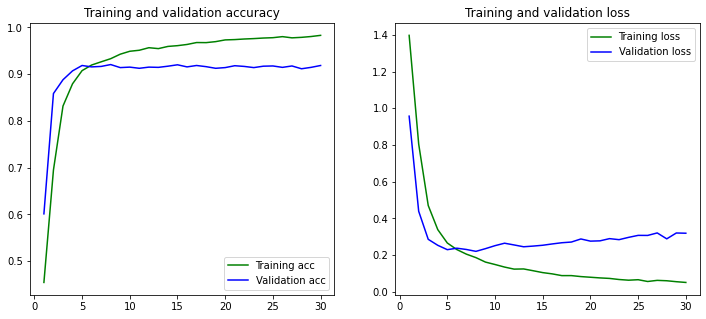

In [ ]:
PlotGraph(history)

In [ ]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.9204999804496765


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([4, 4, 4, ..., 2, 2, 5])

# Performance Matrices

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
cm

array([[250,   9,   3,   0,  11,   2],
       [  6, 198,   0,   0,  11,   9],
       [  1,   4, 644,  40,   3,   3],
       [  2,   0,  24, 132,   1,   0],
       [ 11,   5,   8,   1, 556,   0],
       [  1,  15,   5,   0,   3,  42]])

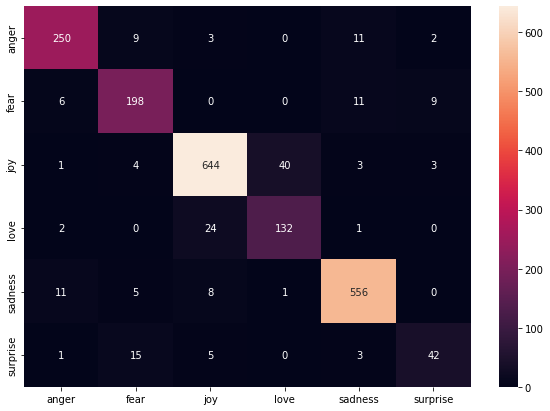

In [ ]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.92      0.91      0.92       275
        fear       0.86      0.88      0.87       224
         joy       0.94      0.93      0.93       695
        love       0.76      0.83      0.80       159
     sadness       0.95      0.96      0.95       581
    surprise       0.75      0.64      0.69        66

    accuracy                           0.91      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.91      0.91      0.91      2000



In [ ]:
Li=['anger','fear','joy','love','sadness','surprise']

In [ ]:
import time

message = ['''
''']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=maxlen)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(predict_class[np.argmax(pred)], (time.time() - start_time)))
No=predict_class[np.argmax(pred)]
print(Li[No])

Message: ['A chest of metal, an eagle’s vision\nA teeth of sour girdle, an insight of taught mentions\nA plunging foot, a never dragging heart\nThere a princess stood, but never a hint of look or any dart\nScorching suns were braved\nTorenting skies were naived\nDust like a life stuck up in every breadth\nBut the bronze turned skin shows his worth of every mile\nA sweet child’s look, an outsmarting tangle\nA heart wrapped up in pure satin\nTo be lent, to without crave given... to the\nBronze man in the shining armour\nA metal built but without any doubt, human emotions he felt\nA mask of ignorance worn,\nA mask of love that was thrown\nDays of blooming flowers, Ages of moving clouds\nA touch of line upon the princess’ radiant skin shone\nA wage of a tower, but yet never held any power...\nHis people mattered most he splattered\nWars of brave ones gone, yet he seemed as strong as sun\nBut just as unique and lovely he was\nA gray tress came along, but never did the princess\nShow a sign 